# Preamble

TODO

## Setup
### Imports



In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import tabulate
import itertools
import unicodedata
import re
from  matplotlib.ticker import FuncFormatter
import os
from pathlib import Path

### Helper Functions

In [104]:
def flatmap(func, *iterable):
    return itertools.chain.from_iterable(map(func, *iterable))

### Style

We configure a heatmap/colour scheme for tables, set a theme for plots and configure the numbers to conform to German customs.

In [2]:
cm = plt.cm.YlOrRd
sns.set_style("whitegrid")
pd.set_option("styler.format.decimal", ",")
pd.set_option("styler.format.precision", 2)
pd.set_option("styler.format.na_rep", "–")

### Assets Export

Finally, we want to set up functions for writing tables and figures to external files, so they can be included in a document.

In [3]:
subdirectory = Path("assets")
subdirectory.mkdir(exist_ok=True)

def write_figure(the_name):
    plt.savefig(subdirectory / f"figure-{the_name}.svg")

def write_table(df, the_name, caption="", heatmap=False, axis=None):
    style = df.style if not heatmap else df.style.background_gradient(axis=axis, cmap=cm)
    with (subdirectory / f"table-{the_name}.tex").open(mode="w") as f:
        f.write(
            (style).highlight_null(props="background-color:white; color:white;").to_latex(
                convert_css=True, 
                hrules=True,
                sparse_index=False,
                environment="longtable", 
                position="!hbt", 
                caption=caption, 
                label="tbl:"+the_name
            )
        )
    with (subdirectory / f"table-{the_name}.html").open(mode="w") as f:
        f.write((style).highlight_null(props="opacity:0").to_html(sparse_index=False))
    with (subdirectory / f"table-{the_name}.md").open(mode="w") as f:
        if caption:
            f.write(f"Table: {caption}\n\n")
        f.write(df.to_markdown(floatfmt=".2f").replace("nan", "\u00a0").replace(".00", "   ").replace(".", ",")) #ma

### Greek/Coptic Alphabet
We also define a table mapping Unicode Greek letters to Unicode Coptic letters.
See [here](#greek-transliteration) for more info.

In [4]:
greek_to_coptic = {
  'α': 'ⲁ',
  'β': 'ⲃ',
  'γ': 'ⲅ', 
  'δ': 'ⲇ',
  'ε': 'ⲉ',
  'ζ': 'ⲍ',
  'η': 'ⲏ',
  'θ': 'ⲑ',
  'ϑ': 'ⲑ',
  'ι': 'ⲓ',
  'κ': 'ⲕ',
  'λ': 'ⲗ',
  'μ': 'ⲙ',
  'ν': 'ⲛ',
  'ξ': 'ⲝ',
  'ο': 'ⲟ',
  'π': 'ⲡ',
  'ρ': 'ⲣ',
  'σ': 'ⲥ',
  'τ': 'ⲧ',
  'υ': 'ⲩ',
  'φ': 'ⲫ',
  'χ': 'ⲭ',
  'ψ': 'ⲯ',
  'ω': 'ⲱ',
  'ς': 'ⲥ',
  'ϗ': 'ⳤ',
  '\u0314': 'ϩ',
  '\u0345': 'ⲓ',
}

greek_to_coptic_ord = {ord(greek): ord(coptic) for greek, coptic in greek_to_coptic.items()}

# Data Processing

## Importing the Data
The CSV file we are going to use contains a large corpus of Greek words and their concrete spellings within Coptic texts, about 200K occurrences.

In [5]:
df = pd.read_csv(os.getenv("ATTESTATIONS_CSV"))
df = df.set_index("id")

/tmp/ipykernel_626454/912060916.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.getenv("ATTESTATIONS_CSV"))


Here are some random examples of these data points:

In [6]:
df.sample(5)

,quote_coptic,quote_english,orthography,encoding,coptic_lemma_id,coptic_lemma,coptic_lemma2,greek_lemma_id,greek_lemma,dialect,...,manuscript_text,earliest,latest,?,collection,material,dialectCode,dialect_group,code,name
id,,,,,,,,,,,,,,,,,,,,,
101919,ⲁⲛⲟⲕ ⲃⲓⲕⲧⲱⲣ ⸌ⲡϣⲉⲛ⸍ⲙⲁⲑⲓⲁⲥ ⲡⲣⲱⲙ ⲉⲥⲟⲩ ϩⲛ ⲡⲧⲟϣ ⲛϣⲙ...,I.Victor.the son of Matthew.the inhabitant of ...,ⲙⲟⲛⲟⲭⲟⲥ,nn.m.sg.dtd,1645,ⲙⲟⲛⲁⲭⲟⲥ,ⲙⲟⲛⲁⲭⲟⲥ,1439,μοναχός,S,...,Ann Arbor - Michigan University - Papyrus Coll...,500.0,499.0,NaN,Ann Arbor - Michigan University - Papyrus Coll...,Papyrus,S,Sahidic Dialects,S,Sahidic
148616,Ⲁⲩⲱ ⲁⲡϩⲁⲅⲓ|ⲟⲥ̄ ϩⲏⲗⲓ︦ⲁ̄ⲥ ^ⲃⲁ|ⲡⲧⲓ︦ⲍⲉ^ ⲛ̄ⲑⲉⲟⲕ|ⲗⲏⲧ...,NaN,ⲃⲁ|ⲡⲧⲓ︦ⲍⲉ,vb.1prf.auxn.obn,480,ⲃⲁⲡⲧⲓⲍⲉ [caus],ⲃⲁⲡⲧⲓⲍⲉ (caus),362,βαπτίζω,S,...,No. unknown (11) - Martyrdom of Elijah,800.0,924.0,NaN,No. unknown (11),Parchment,S,Sahidic Dialects,S,Sahidic
722,ⲟⲩⲥⲟⲉⲓⲧ ⲉⲛⲁ|ⲛⲟⲩϥⲡⲉ ⲡⲣ︥ⲡⲙⲉⲩⲉ ⲙ︥|ⲡ^ⲇⲓⲕⲁⲓⲟⲥ^ ⲡⲣⲓⲛ...,Good fame is the remembering of the ^just^ man...,ⲇⲓⲕⲁⲓⲟⲥ,nn.m.sg.dtd.an,654,ⲇⲓⲕⲁⲓⲟⲥ,ⲇⲓⲕⲁⲓⲟⲥ,535,δίκαιος,Sp,...,Geneva - Fondation Bodmer 6 - Proverbs,300.0,499.0,NaN,Geneva - Fondation Bodmer 6,Parchment,Sp,Sahidic Dialects,S,Proto-Sahidic
174168,ⲕⲁⲧⲁ ⲡⲟⲩⲱϣ ⲙⲡⲉϥ|ⲉⲓ̈ⲱⲧ ⲁϥϫⲓ̈ ⲥⲱⲙⲁ ϩⲛ̄ ⲧ^ⲡⲁⲣⲑⲉⲛⲟ...,NaN,ⲡⲁⲣⲑⲉⲛⲟⲥ,nn.f.sg.dtd,1895,ⲡⲁⲣⲑⲉⲛⲟⲥ,ⲡⲁⲣⲑⲉⲛⲟⲥ,1677,παρθένος,S,...,New York - The Morgan Library and Museum M575 ...,875.0,899.0,892-893,New York - The Morgan Library and Museum M575,Parchment,S,Sahidic Dialects,S,Sahidic
49238,ⲟⲩⲛ̄ ^ⲉⲅⲕⲣⲁⲧⲏⲥ^ ⲛⲁϣ[ⲛ̄] | [ⲉⲅⲕⲣⲁⲧ]ⲏ̣ⲥ̣ ⲉϥ̣ⲣ̣̄ ...,One ^abstainer^ shall [ask [another] abstainer...,ⲉⲅⲕⲣⲁⲧⲏⲥ,nn.gen0.num0.dt0.an,3272,ⲉⲅⲕⲣⲁⲧⲏⲥ,ⲉⲅⲕⲣⲁⲧⲏⲥ,2871,ἐγκρατής,L4,...,Dublin - Chester Beatty Library Codex D - Serm...,375.0,433.0,NaN,Dublin - Chester Beatty Library Codex D,Papyrus,L4,Lycopolitan Dialects,L4,NaN


## Exploring the Data

### Dates of the Texts
The data points originate from texts scattered across multiple centuries.
These are the texts, together with a plausible date range (if available):

In [7]:
df[["manuscript_text", "earliest", "latest"]].set_index("manuscript_text").drop_duplicates()

,earliest,latest
manuscript_text,,
Cambridge - Bible Society's Library pap. Q - Gospel of John,200.0,299.0
Papyrus Nag Hammadi C 002 - Genesis,200.0,399.0
London - British Library Or 4919(5) - Lamentations,NaN,NaN
Leipzig - Universität - Papyrus- und Ostrakasammlung P.Lips. Inv. 2299 - Exodus Apocryphon,200.0,499.0
Moscow - Pushkin Museum I.1.b.523 - P.MoscowCopt 90,200.0,1119.0
...,...,...
Berlin - Ägyptisches Museum P. 8324 - BKU I 18 (Healing amulet),NaN,699.0
London - British Library Or. 5525 - P.Lond.Copt. 1 524 (magical text to protect a woman and her children),NaN,899.0
London - British Library Or. 6800 - Colophon with prayer for Mena bishop of Keft,1000.0,1033.0


Because we may want to try to correlate some spelling variations with the time period at which they occur, we want to know how many texts lack a date (and therefore cannot be used for this analysis):

In [8]:
len(df[pd.isna(df["earliest"]) & pd.isna(df["latest"])]) / len(df)

0.4687119220970162

As we can see, almost half of the attestations of Greek words in Coptic texts lack a plausible date.
This leaves us with about 100K dateable data points. Since there are often two date series—an upper and a lower bound—and it is easier to work with only one series, we use the arithmetic mean of the latest and earliest dates if both are available, otherwise we use the one available date.

In [9]:
def unify_date(row):
    if row["latest"] and row["earliest"]:
        return (row["latest"]+row["earliest"])/2
    elif row["latest"]:
        return row["latest"]
    elif row["earliest"]:
        return row["earliest"]
    else:
        return None

df["date_approximate"] = df.apply(unify_date, axis=1)

We get the following distribution:

<Axes: >

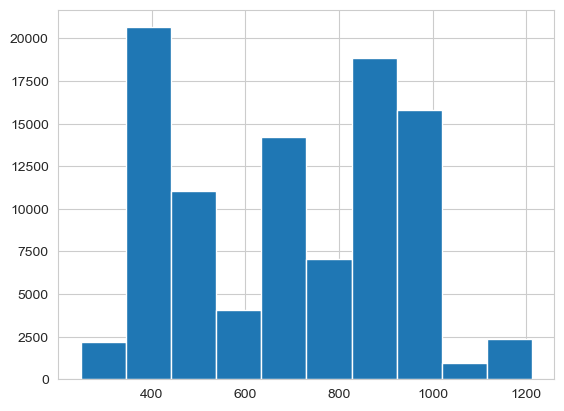

In [10]:
df["date_approximate"].hist()

## Cleaning the Data
Next, it makes sense to strip some columns from the table. For our analysis of orthographical variants, we only need the `orthography` and `greek_lemma` columns (for comparing them against each other).
For further analysis of factors such as date or dialect, we also keep the `dialect` column as well as our new `date_approximate` column.

In [11]:
df_simple = df[["orthography", "greek_lemma", "dialect", "date_approximate"]]

We also want to remove any rows which for some reason either lack an `orthography` or a `greek_lemma`.

In [12]:
df_simple = df_simple.dropna(subset={"orthography", "greek_lemma"})

We also want to remove all rows which are explicitly marked as erroneous (via `sic`) or as abbreviations, i.e. ending with `/` or similar or containing `…` or other common abbreviation characters, e.g. monograms.

In [13]:
df_simple = df_simple[~(
    df_simple["orthography"].str.contains("sic")
    | df_simple["orthography"].str.endswith(("/", "/̅", "/°")) # remove marked abbreviations
    | df_simple["orthography"].str.contains("\d|[….ⳇ⁄?ⳁ⳨Ⳁ⳧ⲋ⳦⳥⳽]", regex=True) # remove lines with numbers or marked abbreviations
)]

The `orthography` column is still littered with all kinds of combining diacritics, letter variants, capital letters or Greek script that have crept in. We therefore create an `orthography_clean` column, applying the following transformations:

In [14]:
df_simple["orthography_clean"] = (
    df_simple["orthography"]
    .str.strip() # remove extraneous whitespace
    .str.lower() # convert capital letters to lower case
    .apply(lambda x: x.translate(greek_to_coptic_ord)) # convert Greek letters that crept in
    .str.replace("ϊ", "ⲓ") # convert precombined accented greek letter
    .str.replace("[\u0305\u0304\ufe24\ufe25\ufe26\u2cf1\u2cf0\u0300]+", "", regex=True) # remove overlines
    .str.replace("[\u2CBB\u2CEF]", "ⲛ", regex=True) # normalize letter ⲛ (written as stroke)
    .str.replace("[ⳅⲹ]", "ⲍ", regex=True) # normalize letter ⲍ
    .str.replace("\u001D|\u0314|\u200E|\u0486|\u02BE|\u2CFF|\u0307|\u0308|\u0301|\u0323|\u0304|\u1DCD|\u0302|\u0306" + "|" + r"col\.b|/|⟦.*?⟧|\\|\[|\]|[‖|´⸤⸥⸢⸣⁅⁆⸖'‹›`’`´:⸌⸍\⸳‧·•·ʾ*]", "", regex=True)
)

By removing all expected alphabetic characters from the orthographies, we can see how many rows still contain unexpected characters:

In [15]:
df_simple["strange_characters"] = df_simple["orthography_clean"].str.replace("[ϯϫϭⲁⲃⲅⲇⲉⲍⲏⲑⲕⲗⲙⲛⲝⲡⲣⲥⲧⲟⲱⲩⲓϩⲫϣ ⲭⳉϥⲯⲡⳤ\u0305]", "", regex=True).apply(lambda x: set(c for c in x))
df_simple[df_simple["strange_characters"].apply(lambda x: len(x) > 0)]

,orthography,greek_lemma,dialect,date_approximate,orthography_clean,strange_characters
id,,,,,,
84790,[ⲑⲏⲥⲁⲩⲣoⲥ],θησαυρός,S,NaN,ⲑⲏⲥⲁⲩⲣoⲥ,{o}
98756,ⲡⲣⲏⲣ[ⲱ]ⲥⲓ̈[c],πλήρωσις,S,749.5,ⲡⲣⲏⲣⲱⲥⲓc,{c}
86252,ⲛ⸌o⸍,νόμισμα,S,724.5,ⲛo,{o}
50102,~,στοιχέω,S,749.5,~,{~}
72393,ⲟⲩⲧoⲥ,οὕτως,S,749.5,ⲟⲩⲧoⲥ,{o}
150531,ϩⲩⲡⲟⲙ̄ō|ⲛⲏ,ὑπομονή,S,NaN,ϩⲩⲡⲟⲙoⲛⲏ,{o}
72021,ⲁⲗⲙⲟⲩⲡⲧⲱ‵ⲛ′,(incertum),S,899.5,ⲁⲗⲙⲟⲩⲡⲧⲱ‵ⲛ′,"{′, ‵}"
72466,ⲡⲉⲣ․ⲓⲭⲣⲓⲥⲙⲁ,περίχρισμα,S,899.5,ⲡⲉⲣ․ⲓⲭⲣⲓⲥⲙⲁ,{․}
77044,[I],(incertum),S,899.5,i,{i}


These remaining cases are neglegible.

## Finding Differences

TODO

<a id="greek-transliteration"></a>
### Transliteration from Greek to Coptic

In the following, we want to compare the (normative) Greek spelling to various actual Coptic spellings.
The Greek and Coptic alphabets are handled by Unicode differently, so trying to find the differences between a word such as δίκαιος and ⲇⲓⲕⲁⲓⲟⲥ
would highlight every letter as different, because the actual codepoints of the Greek and Coptic delta, iota etc. differ.
We therefore need to "transliterate" (using quotes, because the alphabets are essentially the same) either the Coptic words into the Greek alphabet or the Greek words into the Coptic.

Because the Coptic alphabet is a superset of the Greek and we would not be able to handle specifically Egyptian characters such as ϩ, ϣ etc., we choose to convert from Greek to Coptic. 
The following three steps are necessary:

1. NFD-normalization (see [Unicode® Standard Annex #15](https://www.unicode.org/reports/tr15/) for more info): This step splits precomposed i.e. accented Greek letters into the underlying letter and one or more accent codepoints. For example: `ἅγιος` will be split into `α, ʿ, ΄, γ, ι, ο, ς`.
2. Actual transliteration: The Greek characters (and their variants, such as ϑ or ς) are mapped to their Coptic equivalents, *spiritus asper* is mapped to `ϩ`, *iota subscriptum* to normal `ⲓ`, other accents are dropped.
3. Reordering of ϩ-combinations: The last step applied to ἅγιος results in `ⲁϩⲅⲓⲟⲥ`, because according to the NFD specification, the combining breathing mark comes after the letter it applies to. Therefore any group of vowels (or *rho*) followed by ϩ must swap places with it. This also correctly converts `ⲁⲓϩⲣⲉⲱ` (← αἱρέω) to `ϩⲁⲓⲣⲉⲱ`. 

In [16]:
def transliterate(greek):
    normalized = unicodedata.normalize("NFD", greek)
    clean_spiritus_asper = lambda x: re.sub(r"^([ⲣⲁⲉⲏⲓⲟⲱⲩ]+)ϩ", r'ϩ\1', x)
    return clean_spiritus_asper(
        "".join(
            greek_to_coptic[character.lower()]
            for character in normalized
            if character.lower() in greek_to_coptic
        )
    )

See the transliteration in action here:

In [17]:
transliterate("ῥᾳδίως"), transliterate("αἱρέω"), transliterate("ἅγιος")

('ϩⲣⲁⲓⲇⲓⲱⲥ', 'ϩⲁⲓⲣⲉⲱ', 'ϩⲁⲅⲓⲟⲥ')

It works as expected. We can now apply this transformation to the entire `greek_lemma` column:

In [18]:
df_simple["greek_lemma"] = df_simple["greek_lemma"].apply(transliterate)

### *Gestalt* Pattern Matching

The task of finding the places where two spellings of the same word vary, e.g. finding out that the difference between `ⲇⲓⲕⲁⲓⲟⲥ` and `ⲇⲓⲕⲉⲟⲥ` lies in the substitution `ⲁⲓ → ⲉ`.
Is analogous to the common computer science task of [file comparison](https://en.wikipedia.org/wiki/File_comparison).

We can therefore simply use a tool built for file comparison—Python's built-in [difflib](https://docs.python.org/3/library/difflib.html) module—for our analysis.
The algorithm used by this module is known as [*Gestalt* pattern matching](https://en.wikipedia.org/wiki/Gestalt_Pattern_Matching).

Unlike the more commonly used [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance), it works on arbitrarily long groups of characters, so the difference between the strings `ⲁⲣⲁⲯ` and `ⲁⲣⲁⲃⲟⲥ` is characterized as `replace ⲯ → ⲃⲟⲥ` instead of `replace ⲯ → ⲃ, insert ⲟ, insert ⲥ`. As can probably be seen, this better reflects the *gestalt* of the concrete difference in orthography.

But how does it work? Some examples:

1. Find the [longest common substring](https://en.wikipedia.org/wiki/Longest_common_substring) of both spellings. If there are multiple ones of equal length, the one occuring earliest will take precedence. When comparing `ⲁⲣⲁⲯ` and `ⲁⲣⲁⲃⲟⲥ`, the longest common substring is `ⲁⲣⲁ`.
2. Recurse into the left and right of that substring. Neither of the two strings has any characters left of the common substring `ⲁⲣⲁ`, so this recursion subtree is complete. To the right, we have the two strings `ⲯ` and `ⲃⲟⲥ`. We try to find the longest common substring of those two.
3. If there is no common substring, we note the difference as `replace ⲯ → ⲃⲟⲥ`. If one or the other side is empty, this is notes as either `insert XYZ` (`replace ∅ → XYZ`) or `delete XYZ` (meaning  `replace XYZ → ∅`).

Another example, this time comparing `ⲇⲓⲕⲁⲓⲟⲥ` to `ⲇⲓⲕⲉⲟⲥ`:

1. Common subsequences are `ⲇⲓⲕ` and `ⲟⲥ`. We start with `ⲇⲓⲕ`, because it is longer.
2. To the left of `ⲇⲓⲕ` both strings are empty (and thereby equal). To the right we have the strings `ⲁⲓⲟⲥ` and `ⲉⲟⲥ`.
    1. Their longest common substring is `ⲟⲥ`.
    2. To the left we have the strings `ⲁⲓ` and `ⲉ`. To the right both strings are empty (and thereby equal).
3. There is no common substring between `ⲁⲓ` and `ⲉ`. We have therefore found the one differing point. We can characterize the difference as `replace ⲁⲓ → ⲉ`.

This is all done by the `SequenceMatcher` class. Its method `get_opcodes()` returns all changes and where in the string they apply.

In [19]:
from difflib import SequenceMatcher

def get_required_edits(a, b):
    for operation, a_start, a_end, b_start, b_end in SequenceMatcher(
        a=a, b=b, autojunk=False
    ).get_opcodes():
        the_input = a[a_start:a_end]
        if len(the_input) == 0: the_input = "∅"
        the_output = b[b_start:b_end]
        if len(the_output) == 0: the_output = "∅"
        
        context_left = a[:a_start]
        if len(context_left) == 0: context_left = "#"
        context_right = a[a_end:]
        if len(context_right) == 0: context_right = "#"
        if operation == "equal": continue
        yield {"operation": operation, "input": the_input, "output": the_output, "context_left": context_left, "context_right": context_right}

For each change we track `input`, `output`, `context_left` (for our examples `ⲁⲣⲁ` and `ⲇⲓⲕ` respectively) and `context_right` (for our examples `#` (i.e. word boundary) and `ⲟⲥ` respectively).

In [31]:
pd.DataFrame(list(get_required_edits("ⲁⲣⲁⲯ", "ⲁⲣⲁⲃⲟⲥ")) + list(get_required_edits("ⲇⲓⲕⲁⲓⲟⲥ", "ⲇⲓⲕⲉⲟⲥ")))

,operation,input,output,context_left,context_right
0,replace,ⲯ,ⲃⲟⲥ,ⲁⲣⲁ,#
1,replace,ⲁⲓ,ⲉ,ⲇⲓⲕ,ⲟⲥ


Since the `SequenceMatcher` was not built for linguistic applications and is therefore ignorant of phonological processes,
some of its results have to be tweaked so we can more clearly recognize the changes taking place.

#### Post-Processing
##### Detecting Degemination
Comparing the normative spelling ⲑⲁⲗⲁⲥⲥⲁ to the actual spelling ⲑⲁⲗⲁⲥⲁ gives us the following change:

In [55]:
pd.DataFrame(get_required_edits("ⲑⲁⲗⲁⲥⲥⲁ", "ⲑⲁⲗⲁⲥⲁ"))

,operation,input,output,context_left,context_right
0,delete,ⲥ,∅,ⲑⲁⲗⲁⲥ,ⲁ


Even though this is a correct application of the algorithm and reflects the minimum amount of changes needed to transform one string into the other—ⲑⲁⲗⲁⲥ is the longest common substring after all—it does not clearly indicate what might be going on phonetically.

A change from ⲑⲁⲗⲁⲥⲥⲁ to ⲑⲁⲗⲁⲥⲁ is no change of ⲥ-elision (as, for example, `ⲗⲟⲅⲓⲥⲙⲟⲥ` to `ⲗⲟⲅⲓ̈ⲙⲟⲥ` would be), but rather a degemination of ⲥ, which we want to recognise as such.

Therefore we transform all rules of the form $\alpha\to \emptyset / s_L\alpha \_ s_R$ and $\alpha\to\emptyset/s_L\_\alpha s_R$ into $\alpha\alpha\to\alpha / s_L\_s_R$.

In [60]:
def fix_degemination(edit):
    if edit["output"] == "∅":
        if edit["context_left"].endswith(edit["input"]):
            return {
                "input": edit["input"] * 2,
                "output": edit["input"],
                "context_left": edit["context_left"][:-len(edit["input"])],
                "context_right": edit["context_right"]
            }
        elif edit["context_right"].startswith(edit["input"]):
            return {
                "input": edit["input"] * 2,
                "output": edit["input"],
                "context_left": edit["context_left"],
                "context_right": edit["context_right"][len(edit["input"]):]
            }
        else:
            return edit
    else:
        return edit            

This works as expected:

In [64]:
pd.DataFrame(fix_degemination(e) for e in get_required_edits("ⲑⲁⲗⲁⲥⲥⲁ", "ⲑⲁⲗⲁⲥⲁ"))

,input,output,context_left,context_right
0,ⲥⲥ,ⲥ,ⲑⲁⲗⲁ,ⲁ


##### Detecting Gemination

On the other side, there are cases such as `ⲁⲣⲭⲁⲅⲅⲉⲗⲗⲟⲥ` for `ⲁⲣⲭⲁⲅⲅⲉⲗⲟⲥ` and `ⲫⲁⲣⲓⲥⲥⲉⲟⲥ` for `ⲫⲁⲣⲓⲥⲁⲓⲟⲥ`.
Currently, they are analyzed as follows:

In [66]:
pd.DataFrame(list(get_required_edits("ⲁⲣⲭⲁⲅⲅⲉⲗⲟⲥ", "ⲁⲣⲭⲁⲅⲅⲉⲗⲗⲟⲥ")) + list(get_required_edits("ⲫⲁⲣⲓⲥⲁⲓⲟⲥ", "ⲫⲁⲣⲓⲥⲥⲉⲟⲥ")))

,operation,input,output,context_left,context_right
0,insert,∅,ⲗ,ⲁⲣⲭⲁⲅⲅⲉⲗ,ⲟⲥ
1,replace,ⲁⲓ,ⲥⲉ,ⲫⲁⲣⲓⲥ,ⲟⲥ


Again, the detected changes obscure the probable phonetic reality.
The process detected for the first example—ⲗ-insertion—is exceedingly rare and only a spelling error (such as the once attested `ⲕⲁⲑⲗⲟⲗⲓⲕⲟⲛ` for `ⲕⲁⲑⲟⲗⲓⲕⲟⲛ`). Rather, it belongs to the many cases of spontaneous gemination of Greek consonants (such as `ⲑⲁⲗⲗⲁⲥⲥⲁ` for `ⲑⲁⲗⲁⲥⲥⲁ`) or diplographies (such as `ⲁⲛⲁⲥⲁⲥⲧⲁⲥⲓⲥ` for `ⲁⲛⲁⲥⲧⲁⲥⲓⲥ`).

The second example is a bit more involved. It makes sense to analys the change `replace ⲁⲓ → ⲥⲉ` rather as two changes: `insert ⲥ` (or even better: `replace ⲥ → ⲥⲥ`), `replace ⲁⲓ → ⲉ` (which is a common change).

To detect simple geminations as in the first example, we convert all rules of the form $\emptyset\to\alpha/s_L\alpha\_s_R$ and $\emptyset\to\alpha/s_L\_\alpha s_R$ to $\alpha\to\alpha\alpha/s_L\_s_R$ (dual to the above).
Note that this change applies to $\alpha$ of any length, so it will also catch two- or three-character diplographies.

To detect compounded geminations, we convert all rules of the form $t_1\to\alpha t_2/s_L\alpha\_s_R$ into two rules: $\alpha\to\alpha\alpha/s_L\_t_1s_R$, $t_1\to t_2/s_L\_s_R$.

In [70]:
def fix_gemination(edit):
    if edit["input"] == "∅":
        if edit["context_left"].endswith(edit["output"]):
            return [{
                "input": edit["output"],
                "output": edit["output"] * 2,
                "context_left": edit["context_left"][:-len(edit["output"])],
                "context_right": edit["context_right"]
            }]
        elif edit["context_right"].startswith(edit["output"]):
            return [{
                "input": edit["output"],
                "output": edit["output"] * 2,
                "context_left": edit["context_left"],
                "context_right": edit["context_right"][len(edit["output"]):]
            }]
        else:
            return [edit]
    elif edit["output"][0] == edit["context_left"][-1]:
        return [{
            "input": edit["input"],
            "output": edit["output"][1:],
            "context_left": edit["context_left"],
            "context_right": edit["context_right"]
        }, {
            "input": edit["context_left"][-1],
            "output": edit["output"][0] * 2,
            "context_left": edit["context_left"][:-1],
            "context_right": edit["input"]+edit["context_right"],
        }]
    else:
        return [edit]

Applying this method to our examples, we get the expected results:

In [77]:
pd.DataFrame(
    list(flatmap(fix_gemination, get_required_edits("ⲁⲣⲭⲁⲅⲅⲉⲗⲟⲥ", "ⲁⲣⲭⲁⲅⲅⲉⲗⲗⲟⲥ"))) 
    + list(flatmap(fix_gemination, get_required_edits("ⲫⲁⲣⲓⲥⲁⲓⲟⲥ", "ⲫⲁⲣⲓⲥⲥⲉⲟⲥ")))
)

,input,output,context_left,context_right
0,ⲗ,ⲗⲗ,ⲁⲣⲭⲁⲅⲅⲉ,ⲟⲥ
1,ⲁⲓ,ⲉ,ⲫⲁⲣⲓⲥ,ⲟⲥ
2,ⲥ,ⲥⲥ,ⲫⲁⲣⲓ,ⲁⲓⲟⲥ


##### Sub-Alignments

Sometimes, similar to the complex gemination above, two adjacent graphemes display orthographic variation.
An example: the Greek word `ⲡⲁⲛⲧⲟⲕⲣⲁⲧⲱⲣ` is occasionally spelled `ⲡⲁⲛⲧⲱⲅⲣⲁⲧⲱⲣ`. Herein, both the `ⲟ` and the `ⲕ` have been altered.
But since the Gestalt pattern matching algorithm returns the minimum amount of changes, maximising the amount of characters that can be replaced in one go, it comes up with this one replacement:

In [80]:
pd.DataFrame(get_required_edits("ⲡⲁⲛⲧⲟⲕⲣⲁⲧⲱⲣ", "ⲡⲁⲛⲧⲱⲅⲣⲁⲧⲱⲣ"))

,operation,input,output,context_left,context_right
0,replace,ⲟⲕ,ⲱⲅ,ⲡⲁⲛⲧ,ⲣⲁⲧⲱⲣ


But this can—and should—be seen as the combination of two changes that commonly occur on their own as well.
The procedure to separate them from another is a bit more involved than the previous two.

Because we do not want to make too many assumptions with respect to the phonetic reality of the spelling variations (we rather want to find out more about them using this study), we want to be content with implementing a method that makes minimal assumptions and gets the job done. A less parsimonious method would for example extract phonological features (like [DORSAL, +plosive, -voiced] from `ⲕ`) and align the input and output strings based on those, mapping `ⲕ` to `ⲅ` and `ⲟ` to `ⲱ`.

Instead, we merely look at whether a grapheme reflects a consonant ($C$) or a vowel ($V$) and convert rules of the form $(\alpha_V^i)\beta_C^j\gamma_V^{k} \to ({\alpha'}_V^{i'}){\beta'}_C^{j'}{\gamma'}_V^{k'}  / s_L\_s_R$ (meaning (optionally) $i$ vowels followed by $j$ consonants followed by $k$ vowels and so on) into multiple rules $\alpha^i \to \alpha'^{i'} / s_L\_\beta^j\gamma^{k}s_R$, $\beta^j\to {\beta'}^{j'}/s_L\alpha^i\_\gamma^ks_R$, and $\gamma^k\to {\gamma'}^{k'}/s_L\alpha^i\beta^j\_s_R$ and so on. Note that this grouping approach allows $j$ consonant graphemes to be replaced by $j' \gtreqqless j$ (less or greater or equal) graphemes etc.

In [99]:
vowels = {"ⲁ", "ⲉ", "ⲏ", "ⲓ", "ⲟ", "ⲱ", "ⲩ"}

remove_null = lambda x: x.replace("∅", "") if len(x) > 1 else x

def fix_CV_or_VC(edit):
    group_cv = lambda string: [(b, "".join(cs)) for b, cs in itertools.groupby(string, key=lambda x: x in vowels)]
    try:
        input_booleans, input_cv_groups = zip(*group_cv(edit["input"]))
        output_booleans, output_cv_groups = zip(*group_cv(edit["output"]))
        if input_booleans == output_booleans and len(input_booleans) > 1:
            edits = []
            position = 0
            context_left = ""
            context_right = "".join(input_cv_groups)
            for input_cv, output_cv in zip(input_cv_groups, output_cv_groups, strict=True):
                position += len(input_cv)
                edits.append({
                    "input": "".join(input_cv),
                    "output": "".join(output_cv),
                    "context_left": remove_null(edit["context_left"] + context_left),
                    "context_right": remove_null(context_right[position:] + edit["context_right"])
                })
                context_left += "".join(input_cv)
            return edits
        else:
            return [edit]
    except ValueError:
        return [edit]

Concretely, this converts our example rule `ⲟⲕ → ⲱⲅ / ⲡⲁⲛⲧ_ⲣⲁⲧⲱⲣ`, into the following:

In [100]:
pd.DataFrame(flatmap(fix_CV_or_VC, get_required_edits("ⲡⲁⲛⲧⲟⲕⲣⲁⲧⲱⲣ", "ⲡⲁⲛⲧⲱⲅⲣⲁⲧⲱⲣ")))

,input,output,context_left,context_right
0,ⲟ,ⲱ,ⲡⲁⲛⲧ,ⲕⲣⲁⲧⲱⲣ
1,ⲕ,ⲅ,ⲡⲁⲛⲧⲟ,ⲣⲁⲧⲱⲣ


For groups of each one vowel and one consonant being changed (in whichever order — CV, VC — and how often repeated — CVC, CVCV, CVCVCV etc.) our fix works fine.
But if multiple consonants within one group change, e.g. with `ϩⲏϥⲧⲟⲙⲁⲥ` for `ϩⲉⲃⲇⲟⲙⲁⲥ`,
our heuristic manages to separate the vocalic and consonantal parts (`ⲉ → ⲏ` and `ⲃⲇ → ϥⲧ`) but does not get any further.
The rare cases where this happens would have to be looked at individually.

In [101]:
pd.DataFrame(flatmap(fix_CV_or_VC, get_required_edits("ϩⲉⲃⲇⲟⲙⲁⲥ", "ϩⲏϥⲧⲟⲙⲁⲥ")))

,input,output,context_left,context_right
0,ⲉ,ⲏ,ϩ,ⲃⲇⲟⲙⲁⲥ
1,ⲃⲇ,ϥⲧ,ϩⲉ,ⲟⲙⲁⲥ


##### Protecting Vocalic Digraphs
Another problem arises with the analysis of the very common Greek-Coptic word `ⲭⲣⲉⲓⲁ`:

In [102]:
pd.DataFrame(get_required_edits("ⲭⲣⲉⲓⲁ", "ⲭⲣⲓⲁ"))

,operation,input,output,context_left,context_right
0,delete,ⲉ,∅,ⲭⲣ,ⲓⲁ


What is analysed here as a deletion of `ⲉ` in fact reflects a common tendency to write the Greek digraph `ⲉⲓ` as plain `ⲓ`,
pointing to a merger of the phonemes encoded by those letters. That fact is obscured by the removal of the `ⲓ` from input.

A common solution would be to 'protect' the digraphs in question, i.e. convert them into one-character segments (e.g. `ⲉⲓ` into `ë`) and then run the pattern matching algorithm on these modified strings (e.g. `ⲭⲣëⲁ → ⲭⲣⲓⲁ`, resulting in a rule `ë → ⲓ`) and then convert those one-character segments in rule inputs, outputs, left and right contexts back into their respective digraphs. That's what we are going for as well.

We devise arbitrary one-character replacements for all Greek vowel digraphs and define an encoding step and a decoding step:

In [107]:
protected_digraphs = {
    "ⲁⲓ": "ä",
    "ⲉⲓ": "ë",
    "ⲏⲓ": "ḧ",
    "ⲟⲓ": "ö",
    "ⲩⲓ": "ü",
    "ⲱⲓ": "ẅ",
    "ⲁⲩ": "â",
    "ⲉⲩ": "ê",
    "ⲟⲩ": "ô",
    "ⲏⲩ": "ĥ",
    "ⲱⲩ": "ŵ",
}

def protect_digraphs(string):
    result = string
    for digraph, code in protected_digraphs.items():
        result = result.replace(digraph, code)
    return result

def unprotect_digraphs(string):
    result = string
    for digraph, code in protected_digraphs.items():
        result = result.replace(code, digraph)
    return result

def unprotect_edit(edit):
    return {
        "input": unprotect_digraphs(edit["input"]),
        "output": unprotect_digraphs(edit["output"]),
        "context_left": unprotect_digraphs(edit["context_left"]),
        "context_right": unprotect_digraphs(edit["context_right"])
    }

Adding these functions to the mix, we get the desired output:

In [109]:
pd.DataFrame(map(unprotect_edit, get_required_edits(protect_digraphs("ⲭⲣⲉⲓⲁ"), protect_digraphs("ⲭⲣⲓⲁ"))))

,input,output,context_left,context_right
0,ⲉⲓ,ⲓ,ⲭⲣ,ⲁ


##### Putting it All Together

We have now defined all necessary post-processing adjustments and wrap the call to the pattern matching functions so that all fixes are applied automatically on every comparison:

In [110]:
def get_required_edits_improved(x, y):
    return flatmap(fix_CV_or_VC,
        map(fix_degemination,
            flatmap(fix_gemination, 
                map(unprotect_edit,
                    get_required_edits(
                        protect_digraphs(x), 
                        protect_digraphs(y)
                    )
                )
            )
        )
    )

#### Results

We apply this improved pattern match to each pair of `greek_lemma` and `orthography_clean` in our data. (This is the most computationally intensive step of the whole study.)

In [111]:
df_diff = df_simple.apply(
    lambda row: list(get_required_edits_improved(row["greek_lemma"], row["orthography_clean"])), 
    axis=1
).explode().dropna()
df_diff = pd.DataFrame(df_diff.tolist(), index=df_diff.index)
df_diff = pd.merge(df_simple[["greek_lemma", "orthography", "dialect", "date_approximate"]], df_diff, on="id")
df_diff = df_diff[df_diff["greek_lemma"].str.len() > 0]

A large part of the now detected spelling variation originates from morphological differences between the Greek dictionary form (1st person singular for verbs, nominative singular masculine for adjectives and nouns) and the form employed in coptic (a reduced form of the infinitive / the imperative, occasionally the nominative singular neuter, adverbial endings). As the morphological transformation of Greek words into Coptic is not our main focus, we can safely remove those entries:

In [112]:
# remove verbal endings
df_diff = df_diff[~(
    (
        df_diff["input"].str.endswith(("ⲱ", "ⲟⲙⲁⲓ", "ⲙⲓ"))
    ) & (
        df_diff["context_right"] == "#"
    )
)]

# remove nominal endings
df_diff = df_diff[~(
    (df_diff["context_right"] == "#") 
    & (
        (df_diff["input"].isin({"ⲥ", "ⲛ"}) & df_diff["output"].isin({"ⲛ", "ⲩ"}) & df_diff["context_left"].str.endswith("ⲟ"))
        | ((df_diff["input"] == "ⲟⲥ") & (df_diff["output"].isin({"ⲏ", "ⲁ", "ⲱⲛ", "ⲱ", "ⲉ", "ⲟⲩ"})))
        | ((df_diff["input"] == "ⲟⲛ") & (df_diff["output"] == "ⲁ"))
        | ((df_diff["input"] == "ⲩⲥ") & (df_diff["output"] == "ⲏ"))
        | ((df_diff["input"] == "ⲥ") & (df_diff["output"] == "ⲛ"))
        | ((df_diff["input"] == "ⲛ") & (df_diff["output"] == "ⲥ"))
    )
) & ~(
    (df_diff["context_right"] == "ⲥ")
    & (
        ((df_diff["input"] == "ⲟ") & (df_diff["output"] == "ⲏ"))
        | ((df_diff["input"] == "ⲏ") & (df_diff["output"] == "ⲟ"))
    )
)]

# remove adverbial endings
df_diff = df_diff[~(
    (df_diff["context_right"] == "ⲥ") 
    & (df_diff["input"].isin({"ⲟ", "ⲏ"}) & (df_diff["output"] == "ⲱ"))
)]

There are also large amounts of abbreviated Greek words in Coptic texts, e.g. `ⲡⲛⲁ` for `ⲡⲛⲉⲩⲙⲁ`, `ⲭⲥ` for `ⲭⲣⲓⲥⲧⲟⲥ`.
Since deleted letters can give no clues about their phonetic reality, we can also remove all deletions for the most commonly abbreviated words (collected in the `blacklist` variable).

In [113]:
blacklist = {
    ""
    "ⲡⲛⲉⲩⲙⲁ",
    "ⲭⲣⲓⲥⲧⲟⲥ", "ⲭⲣⲏⲥⲧⲟⲥ",
    "ⲥⲧⲁⲩⲣⲟⲥ", "ⲥⲧⲁⲩⲣⲟⲱ",
    "ⲥⲱⲧⲏⲣ",
    "ⲡⲛⲉⲩⲙⲁⲧⲓⲕⲟⲥ",
    "ⲇⲉⲓⲛⲁ",
    "ⲕⲩⲣⲓⲟⲥ",
    "ⲡⲁⲛⲧⲟⲕⲣⲁⲧⲱⲣ",
    "ⲁⲙⲏⲛ" # sometimes ϥⲑ
}


# remove common abbreviations
df_diff = df_diff[~(
    (df_diff["output"] == "∅") & df_diff["greek_lemma"].isin(blacklist)
)]

# Data Presentation and Analysis

## Introduction

### Statistical Prerequisites: The Gini Index

The [Gini index](https://link.springer.com/referenceworkentry/10.1007/978-0-387-32833-1_169) measures the inequality of a distribution. It originated in economics as a description of income inequality, but has since been used to describe inequality / diversity in other areas, such as biological diversity. It can be formulated as
$$I_G = \sum_{i=1}^n\sum_{j=1}^n\frac{|x_i-x_j|}{2n^2\lambda(x)}$$
with the arithmetic mean of the distribution $\lambda(x) = \frac{1}{n}\sum_{i=1}^n x_i$.

In [168]:
def gini(x):
    n = len(x)
    divisor = 2 * n**2 * np.mean(x)
    return sum((abs(x[i] - x[j]) / divisor) for i in range(n) for j in range(n))

The values of $I_G$ can be interpreted as follows:

> The Gini coefficient is zero if there is no
inequality in income distribution and a value
of 1 if the income distribution is completely unequal, so $0 \le I_G \le 1$. The Gini index
is simply the Gini coefficient multiplied by
100, in order to convert it into a percentage.
Therefore, the closer the index is to 100%,the
more unequal the income distribution is. [Dodge 2008](https://link.springer.com/referenceworkentry/10.1007/978-0-387-32833-1_169)

A couple examples. If all elements of the population have an equal share, the Gini index is 0:

In [171]:
gini([1, 1, 1, 1, 1])

0.0

If 20% get 80% of the income, the following Gini index results:

In [173]:
gini([1, 1, 1, 1, 16])

0.6

Applied to the domain of orthographic variation, the Gini index can tell us how specialised certain spelling variations are,
i.e. if they commonly only apply to a few words (which then make up a bigger share of the distribution)
or if they apply equally 

In [169]:
ei_i = df_diff[(df_diff["input"] == "ⲉⲓ") & (df_diff["output"] == "ⲓ")]["greek_lemma"].value_counts()
gini(list(ei_i))

0.7716913760447977

In [187]:
the_input = "ⲉ"
the_output = "ⲩ"

subset = df_diff[(df_diff["input"] == the_input) & (df_diff["output"] == the_output)]["greek_lemma"].values
superset = df_diff[df_diff["greek_lemma"].str.contains(the_input)].values
len(subset) / len(superset)

0.015591079534241168

In [150]:
grouped = df_diff.groupby(["input", "output"])

def stats(group):
    value_counts = group.value_counts()
    gini_index = gini(value_counts)
    gini_index2 = gini2(value_counts)
    size = len(group)
    mode = value_counts.idxmax()
    mode_frequency = value_counts[mode] / size
    return size, mode, round(mode_frequency, 2), round(gini_index, 2)

grouped["greek_lemma"].apply(stats).sort_values(ascending=False)

/tmp/ipykernel_626454/2445813550.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  I_G += abs(x[i] - x[j]) / divisor
/tmp/ipykernel_626454/2445813550.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  I_G += abs(x[i] - x[j]) / divisor
/tmp/ipykernel_626454/2445813550.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  I_G += abs(x[i] - x[j]) / divisor
/tmp/ipykernel_626454/2445813550.py:7: FutureWarning: Series.__getitem__ treati

KeyboardInterrupt: 

In [89]:
df_diff[(df_diff["input"] == "ⲧ") & (df_diff["output"] == "ϥⲧ")]

,greek_lemma,orthography,dialect,date_approximate,input,output,context_left,context_right
id,,,,,,,,


In [68]:
df_diff[(df_diff["input"] * 2 == df_diff["output"])]

,greek_lemma,orthography,dialect,date_approximate,input,output,context_left,context_right
id,,,,,,,,
74308,ⲑⲗⲓⲯⲓⲥ,ⲑⲗⲗⲓⲯⲓⲥ,L5,249.5,ⲗ,ⲗⲗ,ⲑ,ⲓⲯⲓⲥ
8346,ⲥⲁⲡⲫⲉⲓⲣⲟⲥ,ⲥⲁⲡⲡ̣ⲓ̣[ⲣⲟⲥ],F7,NaN,ⲡ,ⲡⲡ,ⲥⲁ,ⲣⲟⲥ
8058,ⲁⲅⲁⲡⲏ,ⲁⲁⲅⲁⲡ[ⲏ],F7,NaN,ⲁ,ⲁⲁ,#,ⲅⲁⲡⲏ
8159,ⲥⲧⲩⲗⲟⲥ,ⲥ̣ⲧⲟⲩⲗⲗⲟⲩⲥ,F7,NaN,ⲗ,ⲗⲗ,ⲥⲧⲩ,ⲥ
8187,ⲥⲁⲡⲫⲉⲓⲣⲟⲥ,ⲥⲁⲡⲡ[ⲓⲣⲟⲥ],F7,NaN,ⲡ,ⲡⲡ,ⲥⲁ,ⲣⲟⲥ
145861,ⲅⲉⲛⲉⲁ,[ⲅⲉ[ⲛⲉ]]ⲉⲁ̣,S,NaN,ⲉ,ⲉⲉ,ⲅⲉⲛ,ⲁ
75298,ⲁⲗⲗⲁ,ⲁⲗⲗⲁⲁ,L5,324.5,ⲁ,ⲁⲁ,ⲁⲗⲗ,#
75449,ⲕⲁⲛ,ⲕⲁⲛⲛ,L5,324.5,ⲛ,ⲛⲛ,ⲕⲁ,#
75462,ⲡⲛⲉⲩⲙⲁ,ⲡⲛ︦ⲁ︦ⲁ,L5,324.5,ⲁ,ⲁⲁ,ⲡⲛⲉⲩⲙ,#


In [ ]:
list(get_required_edits("ⲁⲣⲉⲧⲏ", "ⲁⲣⲏⲧⲉ"))

In [ ]:
import matplotlib
from matplotlib_venn import venn2

initial_sans_serif_fonts = matplotlib.rcParams['font.sans-serif']
system_fonts = matplotlib.font_manager.findSystemFonts(fontpaths="/run/current-system/sw/share/X11/fonts", fontext='otf')
[font for font in system_fonts if "Antin" in font]


In [ ]:
matplotlib.font_manager.fontManager.addfont("/run/current-system/sw/share/X11/fonts/Antinoou.ttf")
matplotlib.rcParams['font.sans-serif'] = ["Antinoou"] + initial_sans_serif_fonts

In [ ]:
the_input = "ⲟ"
the_output = "ⲱ"

thither = df_diff[(df_diff["input"] == the_input) & (df_diff["output"] == the_output)]
context_thither = set(thither["context_left"].values) | set(thither["context_right"].values)

thence = df_diff[(df_diff["input"] == the_output) & (df_diff["output"] == the_input)]
context_thence = set(thence["context_left"].values) | set(thence["context_right"].values)

v = venn2([context_thither, context_thence], (f"{the_input} → {the_output}", f"{the_output} → {the_input}"))

v.get_label_by_id("10").set_text(" ".join(context_thither - context_thence))
v.get_label_by_id("11").set_text(" ".join(context_thither & context_thence))
v.get_label_by_id("01").set_text(" ".join(context_thence - context_thither))

In [ ]:
thence[thence["context_left"] == "ⲡ"]